# Kriging Approximation of PDE Output With Active Subspaces

__Paul Constantine__, Colorado School of Mines, <pconstan@mines.edu>

__Eric Dow__, Massachusetts Institute of Technology, <ericdow@mit.edu>

__Qiqi Wang__, Massachusetts Institute of Technology, <qiqi@mit.edu>

__Ryan Howard__, Colorado School of Mines, <ryhoward@mines.edu>

<br>

In this notebook, we'll be summarizing the active subspaces-based kriging approximation of PDE output presented in [[1]][R1].

### Introduction

Complex physical models with uncertain inputs are often subject to _uncertainty quantification_ (UQ) to better understand how the model's output changes when the inputs are varied. Monte Carlo methods are the most straightforward method of UQ, but because they converge slowly and models are becoming increasingly expensive, response surfaces are increasingly employed as an alternative. However, response surface methods suffer the 'curse of dimensionality': the expense of constructing these surfaces increases rapidly as the input space's dimension increases. One way around this curse is to perform sensitivity analysis: identify inputs that are more important in determining output, and construct response surfaces by focusing only on the most important parameters.

*Active Subspaces* is an emerging method of global sensitivity analysis that identifies directions in the input space (not necessarily coordinate directions) along which the output varies much more than in the orthogonal directions. Response surfaces (and other methods) can be more efficiently applied in the subspace defined by the most important directions in the input space. Here, we will describe this method and demonstrate its efficacy by applying it to a high-dimensional elliptic PDE model.

### Active Subspaces

Consider a scalar-valued, differentiable function $f(\mathbf x)$, $\mathbf x\in \chi\subseteq R^m$, where we assume $\chi$ is centered at the origin, and let $\rho$ be a bounded probability density on $\chi$:

$$
\rho(\mathbf x) > 0,\ \mathbf x\in\chi,\ \ \ \ \ \rho(\mathbf x)=0,\ \mathbf x\not\in\chi.
$$

Active subspace methodololgy is based on the matrix

$$
\mathbf C = \int\nabla f(\mathbf x)\,\nabla f(\mathbf x)^T\ \rho(\mathbf x)\ d\mathbf x = \mathbf W\Lambda\mathbf W^T,
$$

where $\mathbf W$ is the matrix of eigenvectors and $\Lambda$ is the diagonal matrix of eigenvalues in descending order. The $i^{th}$ eigenvalue quantifies the change of $f$ along the $i^{th}$ eigenvector: $\int(\mathbf w_i^T\ \nabla f(\mathbf x))^2\rho(\mathbf x)\ d\mathbf x = \lambda_i$; if $\lambda_i$ is small, $f$ tends to be relatively constant along $\mathbf w_i$. To define the active subspace, we partition the eigendecomposition as:

$$
\mathbf W = \left[\begin{matrix}\mathbf W_1 & \mathbf W_2\end{matrix}\right],\ \ \Lambda = \left[\begin{matrix}\Lambda_1 & \\ & \Lambda_2\end{matrix}\right],
$$

where $\mathbf W_1$ contains the first $n$ (out of $m$) eigenvectors and $\Lambda_1$ has the first $n$ eigenvalues (this partition will be valid if $\lambda_n > \lambda_{n+1}$). The active subspace is the span of $\mathbf W_1$'s columns; perturbations along these directions tend to change $f$ more than in the orthogonal directions. For any $\mathbf x\in R^m,\ \mathbf x = \mathbf W\mathbf W^T\mathbf x = \mathbf W_1 \mathbf W_1^T \mathbf x + \mathbf W_2\mathbf W_2^T\mathbf x = \mathbf W_1\mathbf y + \mathbf W_2 \mathbf z$. $\mathbf y = \mathbf W_1^T\mathbf x$ are called the active variables and $\mathbf z = \mathbf W_2^T\mathbf x$ the inactive variables. The eigenvalues also quantify the average variation of $f$ with respect to the active and inactive variables: $\int\nabla_{\mathbf y}f(\mathbf x)^T\nabla_{\mathbf y}f(\mathbf x)\ \rho(\mathbf x)\ d\mathbf x = \lambda_1+\cdots+\lambda_n$ and $\int\nabla_{\mathbf z}f(\mathbf x)^T\nabla_{\mathbf z}f(\mathbf x)\ \rho(\mathbf x)\ d\mathbf x = \lambda_{n+1}+\cdots+\lambda_m$, where $\nabla_{\mathbf y}f(\mathbf x)$ and $\nabla_{\mathbf z}f(\mathbf x)$ are gradients of $f$ with respect to the active and inactive variables. The distribution $\rho(\mathbf x)$ can be written as a joint density of $\mathbf y$ and $\mathbf z$: $\rho(\mathbf x) = \rho(\mathbf W_1\mathbf y + \mathbf W_2 \mathbf z) = \rho(\mathbf y, \mathbf z)$ (if $\rho$ is standard Gaussian, marginal and conditional densities of $\mathbf y$ and $\mathbf z$ will also be standard Gaussian).

If $\lambda_{n+1},\dots,\lambda_m$ are small, we can approximate $f$ as

$$
f(\mathbf x)\approx G(\mathbf y) = \int f(\mathbf W_1\mathbf y + \mathbf W_2\mathbf z)\ \rho(\mathbf z|\mathbf y)\ d\mathbf z.
$$

$G$ is the conditional average of $f$ given $y$; if $f$ is relatively constant in $\mathbf z$, we expect this to be a good approximation. The MSE of this approximation is bounded by 

$$
\int\left(f(\mathbf x) - G(\mathbf W_1^T\mathbf x)\right)^2\ \rho(\mathbf x)\ d\mathbf x \leq C_1(\lambda_{n+1} + \cdots + \lambda_m),
$$

where $C_1$ is a constant that depends only on $\chi$ and $\rho$. $G$ is difficult to compute, so we can use simple Monte Carlo integration to approximate it:

$$
G(\mathbf y) \approx \hat G(\mathbf y) = \frac 1 N\sum_{i=1}^N f(\mathbf W_1\mathbf y + \mathbf W_2\mathbf z_i),
$$

where $\{\mathbf z_i\}_{i=1}^N$ are drawn independently from $\rho(\mathbf z|\mathbf y)$. The error bound on the resulting approximation is

$$
\int\left(f(\mathbf x) - \hat G(\mathbf W_1^T\mathbf x)\right)^2\ \rho(\mathbf x)\ d\mathbf x \leq C_1\left(1 + \frac 1 N\right)(\lambda_{n+1} + \cdots + \lambda_m).
$$

The advantage to using these approximations is that we can now build a response surface to approximate $f$ in $n<m$ dimensions. Let $\{\mathbf y_k\}_{k=1}^P$ be a design on the space of active variables and let $\hat G_k = \hat G(\mathbf y_k)$. We approximate $f(\mathbf x)\approx \tilde G(\mathbf y) = \mathcal R(\mathbf y;\hat G_1,\dots,\hat G_P)$, where $\mathcal R$ is a response surface trained with $\{\hat G_k\}_{k=1}^P$. If we assume the response surface error is bounded by $\int \left(\hat G(\mathbf y) - \tilde G(\mathbf y)\right)^2\rho(\mathbf y|\mathbf z)\ d\mathbf y \leq C_2\delta\ \forall \mathbf z$, where $\delta$ depends on only $\mathcal R$ and $P$ and $C_2$ depends on $\rho$ and $\chi$, then the total error is bounded by

$$
\int\left(f(\mathbf x) - \tilde G(\mathbf W_1^T\mathbf x)\right)^2\ \rho(\mathbf x)\ d\mathbf x \leq C_1\left(1 + \frac 1 N\right)(\lambda_{n+1} + \cdots + \lambda_m) + C_2\delta.
$$

Of course we can't generally compute the matrix $\mathbf C$ analytically, so we approximate it with simple Monte Carlo: draw $\{\mathbf x_i\}_{i=1}^N$ from $\rho$ and compute $\nabla f(\mathbf x_i)$ for each $i$, then

$$
\mathbf C\approx \hat{\mathbf C} = \frac 1 N\sum_{i=1}^N \nabla f(\mathbf x_i)\ \nabla f(\mathbf x_i)^T = \hat{\mathbf W}\hat\Lambda\hat{\mathbf W}^T.
$$

The estimated active and inactive variables are $\hat{\mathbf y} = \hat{\mathbf W}_1^T\mathbf x$ and $\hat{\mathbf z} = \hat{\mathbf W}_2^T\mathbf x$, respectively. The error in the estimated subspace, $\epsilon = ||\hat{\mathbf W}_1^T\mathbf W_2||$ is inversely proportional to $\lambda_{n} - \lambda_{n+1}$, and we can define our approximation as

$$
f(\mathbf x) \approx G_\epsilon(\hat{\mathbf W}_1^T\mathbf x) = \int f(\hat{\mathbf W}_1\hat{\mathbf y} + \hat{\mathbf W}_2\hat{\mathbf z}) \rho(\hat{\mathbf z}|\hat{\mathbf y})d\hat{\mathbf z}
$$

with error bound

$$
\int\left(f(\mathbf x) - G_\epsilon(\hat{\mathbf W}_1^T\mathbf x)\right)^2\ \rho(\mathbf x)\ d\mathbf x \leq C_1\left(\epsilon(\lambda_{1} + \cdots + \lambda_n)^{1/2} + (\lambda_{n+1} + \cdots + \lambda_m)^{1/2}\right)^2.
$$

We can approximate $G_\epsilon$ using simple Monte Carlo in the same way we approximate $G$:

$$
G_\epsilon(\hat{\mathbf y})\approx \hat{G}_\epsilon(\hat{\mathbf y}) = \frac 1 N\sum_{i=1}^N f(\hat{\mathbf W}_1\hat{\mathbf y} + \hat{\mathbf W}_2\hat{\mathbf z}_i),
$$

which has error bound

$$
\int\left(f(\mathbf x) - \hat G_\epsilon(\hat{\mathbf W}_1^T\mathbf x)\right)^2\ \rho(\mathbf x)\ d\mathbf x \leq C_1\left(1+\frac 1 N\right)\left(\epsilon(\lambda_{1} + \cdots + \lambda_n)^{1/2} + (\lambda_{n+1} + \cdots + \lambda_m)^{1/2}\right)^2.
$$

Lastly, we can construct a response surface approximation in the active subspace by choosing a design $\{\hat{\mathbf y}_k\}_{k=1}^P$, evaluating $\hat G_{\epsilon,k} = \hat G_\epsilon (\hat{\mathbf y}_k),\ k=1,\dots,P$, and approximating $\hat G_\epsilon(\hat{\mathbf y})\approx \tilde G_\epsilon(\hat{\mathbf y}) = \mathcal R(\hat{\mathbf y};\hat G_{\epsilon,1},\dots,\hat G_{\epsilon,k})$, where $\mathcal R$ is a response surface trained with the points $\hat G_{\epsilon,1},\dots,\hat G_{\epsilon,P}$. This last layer of approximation has error bounded by 

$$
\int\left(f(\mathbf x) - \tilde G_\epsilon(\hat{\mathbf W}_1^T\mathbf x)\right)^2\ \rho(\mathbf x)\ d\mathbf x \leq C_1\left(1+\frac 1 N\right)\left(\epsilon(\lambda_{1} + \cdots + \lambda_n)^{1/2} + (\lambda_{n+1} + \cdots + \lambda_m)^{1/2}\right)^2 + C_2\delta.
$$

In summary, we have a function, $f(\mathbf x)$, that we'd like to approximate, and we do this in several layers: a low-dimensional conditional average, $G(\mathbf y)$; an approximated conditional average, $\hat G(\mathbf y)$; a response surface on this approximation, $\tilde G(\mathbf y)$; and versions of these using the _approximated_ active subspace: $G_\epsilon(\mathbf y),\ \hat G_{\epsilon}(\mathbf y)$, and $\tilde G_\epsilon(\mathbf y)$.

### Kriging Surfaces

We'll now describe a heuristic process for constructing a kriging approximation of $f$ on the active subspace. For simplicity, we'll assume we have an exact computation of $\mathbf W$ and $\Lambda$. First, we need to choose the design on the active subspace, and to this end, we focus on two choices of $\chi$ and $\rho$: standard Gaussian on $R^m$ and uniform density on the hypercube $\chi = [-1,1]^m$. In the Gaussian case, the density $\rho(\mathbf y)$ is also standard Gaussian and we choose the design as a simple tensor product, each univariate design covering three standard deviations (e.g., a design on $R^2$ with 3 points per dimension would be $\{-3, 0, 3\}\times \{-3, 0, 3\}$). In the uniform case, the marginal density will be non-uniform and the active subspace's domain will be a zonotope on $R^n$; algorithms can be used to determine the zonotope's vertices and these can be given to mesh generators to compute a design.

For each $\mathbf y_k$ in our design, we choose one $\mathbf x_k$ to compute $\hat G_k = f(\mathbf x_k)$; in the Gaussian case, we can choose $\mathbf x_k = \mathbf W_1 \mathbf y_k$ and in the uniform case, we must choose $\mathbf x_k$ such that $\mathbf y_k = \mathbf W_1^T\mathbf x_k$ and $\mathbf x_k\in[-1,1]^m$, which can be found with linear programming. The set $\{(\mathbf y_k, \hat G_k)\}$ is used to train the kriging surface.

Since there is noise in using $\hat G$ to estimate $G$, we want to incorporate this noise into our kriging model. To this end, we choose the covariance of the training data to be

$$
Cov\left[\tilde G(\mathbf y_{k_1}), \tilde G(\mathbf y_{k_2})\right] = K(\mathbf y_{k_1}, \mathbf y_{k_2}) + \eta^2\delta(k_1, k_2),
$$

where $\delta(k_1, k_2) = 1$ if $k_1=k_2$ and 0 otherwise, and 

$$
K(\mathbf y_{k_1}, \mathbf y_{k_2}) = \exp\left(-\sum_{i=1}^n\frac{(y_{k_1,i} - y_{k_2,i})^2}{2l_i^2}\right).
$$

We choose a quadratic mean term, and are left to estimate the correlation lengths $l_i$ and the noise parameter $\eta^2$. After we have these estimates, the coefficients of the quadratic mean and the linear combination of training data are computed as usual. We could use maximum likelihood methods to estimate $l_i$ and $\eta^2$, but we choose to use active subspace results to inform our estimates. To this end, first we approximate the directional derivative of $f$ along $\mathbf w_i$ using a finite difference: $\nabla f^T\mathbf w_i\approx\frac 1 \delta (f(\mathbf x + \delta \mathbf w_i)-f(\mathbf x))$, and decompose $f(\mathbf x) = f_0 + f'(\mathbf x)$, where $f_0 = E[f]$ (we use $E[f]$ and $V[f]$ as shorthands to denote integrals of $f$). Now,

\begin{align*}
\lambda_i &= E[(\nabla f^T\mathbf w_i)^2]\\
&\approx \frac{1}{\delta^2}E\left[(f(\mathbf x + \delta\mathbf w_1) - f(\mathbf x))^2\right]\\
&= \frac{1}{\delta^2}\left[(f'(\mathbf x + \delta\mathbf w_1) - f'(\mathbf x))^2\right]\\
&=\frac{2}{\delta^2}\left(\sigma^2-Cov[f'(\mathbf x + \delta\mathbf w_1), f'(\mathbf x)]\right),
\end{align*}

where $\sigma^2 = V[f]$. Rearranged: $Corr[f'(\mathbf x + \delta\mathbf w_1), f'(\mathbf x)] = 1 - \frac{\lambda_i\delta^2}{2\sigma^2}$. A univariate squared exponential correlation function with length parameter $l$ has a Taylor expansion of $\exp(-\frac{\delta^2}{2l^2}) = 1 - \frac{\delta^2}{2l^2} + \cdots$; comparing these, we can estimate $l_i$ as $l_i^2 = \frac{\sigma^2}{\lambda_i}$.

We know from the active subspace analysis that $\sigma^2 = V(f)\leq C_1(\lambda_{1}+\cdots+\lambda_m)$. Because this is a loose bound, we assume that there is an $\alpha\leq C_1$ such that $\sigma^2 = \alpha(\lambda_1+\cdots+\lambda_m)$. If $\chi = R^m$ and $\rho$ is standard Gaussian, $C_1\leq 1$, and if $\chi = [-1,1]^m$ and $\rho$ is uniform, $C_1\leq\frac{2\sqrt m}{\pi}$. To find a lower bound on $\alpha$, we use the biased estimate of variance: $\hat\sigma^2 = \frac 1 M\sum_{j=1}^M(f_j-\hat f_0)^2$, where $\hat f_0$ is the empirical mean of $\{f_j\}$; we expect the bias to be significant enough that $\hat \sigma^2\leq\alpha(\lambda_1+\cdots+\lambda_m)$, so that $\alpha$ is bounded by 

$$
\frac{\hat\sigma^2}{\lambda_1+\cdots+\lambda_m}\leq\alpha\leq C_1.
$$

$\alpha$ can now be treated as a hyperparameter and estimated using maximum likelihood. Once we have an estimate for $\alpha$, we set $\sigma^2 = \alpha(\lambda_1+\cdots+\lambda_m)$ and $\eta^2 = \alpha(\lambda_{n+1}+\cdots+\lambda_m)$.

### References:

[[1]][R1] P.G. Constantine, E. Dow, and Q. Wang. _Active subspaces in theory and practice: applications to kriging surfaces_. SIAM J. Sci. Comput., 36(4), A1500–A1524

[[2]][R2] P.G. Constantine. _Active Subspaces: Emerging Ideas for Dimension Reduction in Parameter Studies_. SIAM, 2015. ISBN: 978-1-611973-85-3

[R1]: http://dx.doi.org/10.1137/130916138
[R2]: http://bookstore.siam.org/sl02/

### Acknowledgments

This material is based upon work supported by the U.S. Department of Energy Office of Science, Office of Advanced Scientific Computing Research, Applied Mathematics program under Award Number DE-SC-0011077.

<br>

### Demonstration on an Elliptic PDE

We'll now demonstrate active-subspaces analysis on output derived from an elliptic PDE using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces). First, we describe the model.

Let $u(\mathbf s, \mathbf x)$ satisfy the PDE

$$
-\nabla_{\mathbf s}\cdot(a\nabla_{\mathbf s}u) = 1,\ \ \ \mathbf s\in[0,1]^2.
$$

Homogeneous Dirichlet boundary conditions are used on the left, top, and bottom boundaries of the domain (denote these boundaries by $\Gamma_1$), and a homogeneous Neumann condition is used on the right boundary (denoted by $\Gamma_2$). The log of the coefficients $a(\mathbf s, \mathbf x)$ is given by a truncated Karhunen-Loeve series:

$$
\log(a(\mathbf s, \mathbf x)) = \sum_{i=1}^mx_i\gamma_i\phi_i(\mathbf s),
$$

where $\{x_i\}\sim_{iid} N(0,1)$ and the $\{\phi_i(\mathbf s),\gamma_i\}$ are eigenpairs of the correlation function $\mathcal C(\mathbf s, \mathbf t) = \exp\left(-\beta^{-1}||\mathbf s - \mathbf t||_1\right)$ (we will study the performance of active subspaces for $\beta=1$ and $\beta=.01$). We choose $m=100$, so that $\chi = R^{100}$ and $\rho$ is standard Gaussian. Our scalar quantity of interest is given by 

$$
\frac{1}{|\Gamma_2|}\int_{\Gamma_2}u(\mathbf s,\mathbf x)d\mathbf s.
$$

The matrix equation defining the approximated solution at our mesh nodes is $\mathbf K\mathbf u = \mathbf f$, where $\mathbf K = \mathbf K(\mathbf x)$ is symmetric and positive definite for $\mathbf x\in\chi$. The coresponding discretized approximation of our quantity of interest is 

$$
f(\mathbf x) = \mathbf c^T\mathbf M\mathbf u(\mathbf x)\approx\frac{1}{|\Gamma_2|}\int_{\Gamma_2}u(\mathbf s,\mathbf x)d\mathbf s,
$$

where $\mathbf M$ is the symmetric mass matrix and the components of $\mathbf c$ corresponding to $\Gamma_2$'s mesh nodes are 1 and the rest are 0. For any constant vector $\mathbf y$, $f = \mathbf c^T\mathbf M\mathbf u - \mathbf y^T(\mathbf K\mathbf u - \mathbf f)$; differentiating with respect to $x_i$, we find

$$
\frac{\partial f}{\partial x_i} = (\mathbf c^T\mathbf M - \mathbf y^T\mathbf K)\frac{\partial \mathbf u}{\partial x_i} - \mathbf y^T\frac{\partial \mathbf K}{\partial x_i}\mathbf u.
$$

If $\mathbf y$ is chosen so that $\mathbf c^T\mathbf M - \mathbf y^T\mathbf K = 0$, then $\frac{\partial f}{\partial x_i} = - \mathbf y^T\frac{\partial \mathbf K}{\partial x_i}\mathbf u$. After solving the adjoint problem, we use this formula to compute $\nabla_{\mathbf x} f$ ($\frac{\partial \mathbf K}{\partial x_i}$ is easy to compute from the derivative of $a(\mathbf s,\mathbf x)$).

We now code up this example using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces). The code contained in the pde_model.py file is used to approximate the PDE solution and it relies on Qiqi Wang's [Numpad](https://github.com/qiqi/numpad); you will need this installed if you want to run this notebook.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import active_subspaces as ac
from pde_model import PDESolver

First we draw 300 samples from the 100-variable standard normal distribution and we compute the values and gradients of the quantity of interest at these points.

In [2]:
#Solvers used to approximate solutions for short and long correlation lengths
solver_short = PDESolver('short')
solver_long = PDESolver('long')

#M random samples at which to compute gradients
x = np.random.multivariate_normal(np.zeros(100), np.eye(100), (300))

#Computed gradients 
grad_short = ac.utils.simrunners.SimulationGradientRunner(solver_short.grad_qoi).run(x)
grad_long = ac.utils.simrunners.SimulationGradientRunner(solver_long.grad_qoi).run(x)

#Computed qoi values
y_short = ac.utils.simrunners.SimulationRunner(solver_short.qoi).run(x)
y_long = ac.utils.simrunners.SimulationRunner(solver_long.qoi).run(x)

Now we create subspace objects for both correlation lengths and approximate the active subspaces with our gradient samples.

In [3]:
#Subspace objects for each correlation length
ss_short, ss_long = ac.subspaces.Subspaces(), ac.subspaces.Subspaces()

#Compute the active subspaces with the gradient samples and make them 2-dimensional to plot
#the first 2 eigenvectors
ss_short.compute(df=grad_short); ss_short.partition(2)
ss_long.compute(df=grad_long); ss_long.partition(2)

Next we plot the first two eigenvectors for each correlation length.

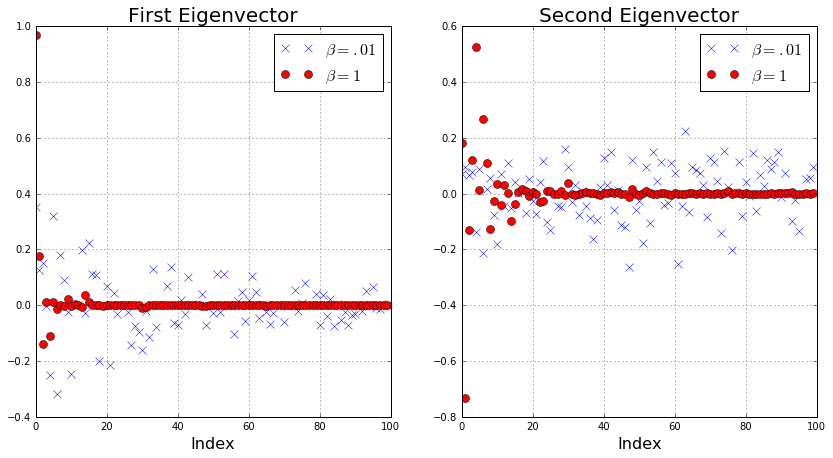

In [4]:
#Plot the first 2 eignevectors for each correlation length
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].plot(np.arange(100), ss_short.W1[:,0], 'bx', ms=8, label=r'$\beta=.01$')
axes[0].plot(np.arange(100), ss_long.W1[:,0], 'ro', ms=8, label=r'$\beta=1$')
axes[0].grid(True)
axes[0].legend(fontsize=16)
axes[0].set_xlabel('Index', fontsize=16)
axes[0].set_title('First Eigenvector', fontsize=20)

axes[1].plot(np.arange(100), ss_short.W1[:,1], 'bx', ms=8, label=r'$\beta=.01$')
axes[1].plot(np.arange(100), ss_long.W1[:,1], 'ro', ms=8, label=r'$\beta=1$')
axes[1].grid(True)
axes[1].legend(fontsize=16)
axes[1].set_xlabel('Index', fontsize=16)
axes[1].set_title('Second Eigenvector', fontsize=20)

Components of the first eigenvector with higher absolute value indicate higher sensitivity to the corresponding parameter. We see the weight in the first eigenvector is more evenly distributed in the short correlation length, which means most of the parameters are important in characterizing output in that case, compared to the long correlation length for which most parameters (those with high indices) are unimportant in characterizing output.

Now we'll construct one-dimensional response surfaces for each correlation length using both the active subspace and a subspace consisting of the variable whose weight in the first eignevector is largest (the most locally impotant variable at the origin in the parameter space).

In [5]:
#Gaussian Process approximation objects for each correlation length and Active Subspaces
#and local sensitivity methods
RS_short_AS = ac.utils.response_surfaces.RadialBasisApproximation(2)
RS_long_AS = ac.utils.response_surfaces.RadialBasisApproximation(2)
RS_short_SENS = ac.utils.response_surfaces.RadialBasisApproximation(2)
RS_long_SENS = ac.utils.response_surfaces.RadialBasisApproximation(2)

#Make the active subspaces 1-dimensional
ss_short.partition(1); ss_long.partition(1)

#Get the indices of the most locally important variables 
SENS_short_v1 = np.argmax(np.abs(ss_short.W1))
SENS_long_v1 = np.argmax(np.abs(ss_long.W1))

#Inputs used for training the active subspaces Kriging surfaces
y_train = np.array([-3, -1.5, 0, 1.5, 3]).reshape((5, 1))
x_train_short = y_train.dot(ss_short.W1.T)
x_train_long = y_train.dot(ss_long.W1.T)

#Inputs for training the local-sensitivity-based response surfaces
x_train_short_SENS = np.zeros((5, 100))
x_train_short_SENS[:,SENS_short_v1] = np.array([-3, -1.5, 0, 1.5, 3])
x_train_long_SENS = np.zeros((5, 100))
x_train_long_SENS[:,SENS_long_v1] = np.array([-3, -1.5, 0, 1.5, 3])

#Get model output at the training input values
f_train_short_AS = ac.utils.simrunners.SimulationRunner(solver_short.qoi)\
    .run(x_train_short)
f_train_long_AS = ac.utils.simrunners.SimulationRunner(solver_long.qoi)\
    .run(x_train_long)
f_train_short_SENS = ac.utils.simrunners.SimulationRunner(solver_short.qoi)\
    .run(x_train_short_SENS)
f_train_long_SENS = ac.utils.simrunners.SimulationRunner(solver_long.qoi)\
    .run(x_train_long_SENS)

#Train the response surfaces
RS_short_AS.train(y_train, f_train_short_AS, e=ss_short.eigenvals)
RS_long_AS.train(y_train, f_train_long_AS, e=ss_long.eigenvals)
RS_short_SENS.train(y_train, f_train_short_SENS)
RS_long_SENS.train(y_train, f_train_long_SENS)

#Alter the correlation length, l, to agree with the paper
RS_long_AS.ell = np.array([[1.0]])

Now we make plots showing the quantity of interest against the subspace variable (the active variable or the most locally important raw input variable). If the subspace is of good quality, we expect to see a tight univariate trend with little deviation around it.

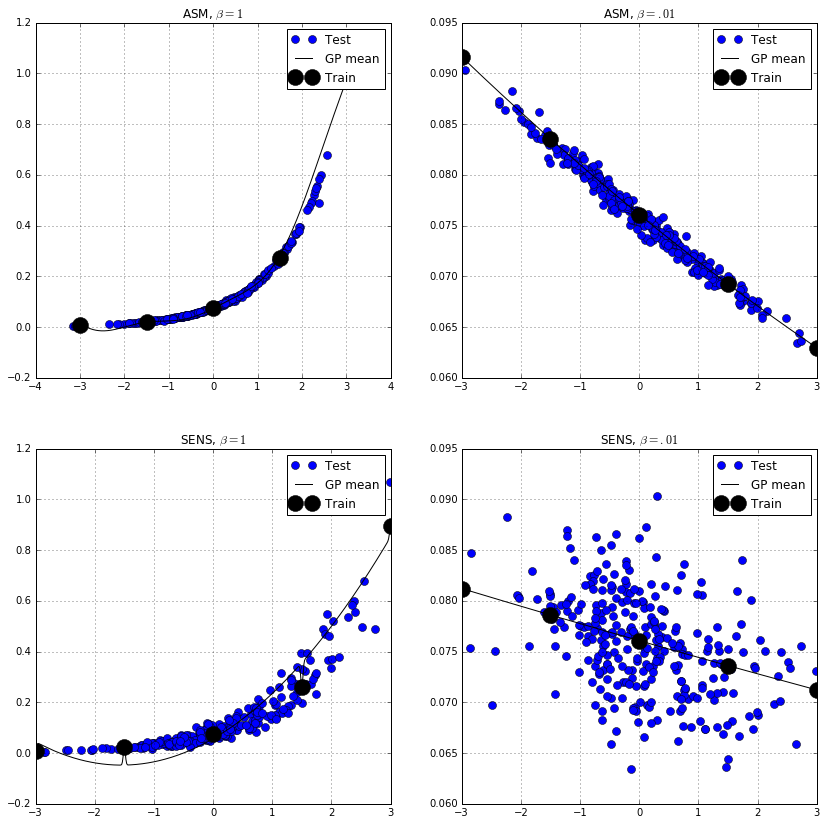

In [6]:
#Make summary plots showing output vs the active (or most locally important) variable

fig, axes = plt.subplots(2, 2, figsize=(14, 14)); axes = axes.reshape(4)

y = np.linspace(-3, 3, 500)[:,None]

axes[0].plot(x.dot(ss_long.W1), y_long, 'bo', ms=8, label='Test')
axes[0].plot(y, RS_long_AS.predict(y)[0], 'k-', label='GP mean')
axes[0].plot(y_train, f_train_long_AS, 'ko', ms=16, label='Train')
axes[0].grid(True)
axes[0].legend()
axes[0].set_title(r'ASM, $\beta = 1$')

axes[1].plot(x.dot(ss_short.W1), y_short, 'bo', ms=8, label='Test')
axes[1].plot(y, RS_short_AS.predict(y)[0], 'k-', label='GP mean')
axes[1].plot(y_train, f_train_short_AS, 'ko', ms=16, label='Train')
axes[1].grid(True)
axes[1].legend()
axes[1].set_title(r'ASM, $\beta = .01$')

axes[2].plot(x[:,SENS_long_v1], y_long, 'bo', ms=8, label='Test')
axes[2].plot(y, RS_long_SENS.predict(y)[0], 'k-', label='GP mean')
axes[2].plot(y_train, f_train_long_SENS, 'ko', ms=16, label='Train')
axes[2].grid(True)
axes[2].legend()
axes[2].set_title(r'SENS, $\beta = 1$')

axes[3].plot(x[:,SENS_short_v1], y_short, 'bo', ms=8, label='Test')
axes[3].plot(y, RS_short_SENS.predict(y)[0], 'k-', label='GP mean')
axes[3].plot(y_train, f_train_short_SENS, 'ko', ms=16, label='Train')
axes[3].grid(True)
axes[3].legend()
axes[3].set_title(r'SENS, $\beta = .01$')

We see a very tight univariate trend for the active subspace and long correlation length. For the long correlation length, the locally-constructed subspace has a fairly tight trend, but it is much less tight and the kriging mean's relative spread around the training data reflects this. For the short correlation length, the active subspace displays a fairly tight trend (though less tight than the long case) while the local subspace shows almost no trend. This makes sense because, as we've already mentioned, the first eigenvector in the short case weights many parameters roughly evenly, meaning many are important in characterizing output; focusing on one, even the most important, will leave out the sizable effects of the other parameters.

Now we repeat the kriging training process with two-dimensional response surfaces constructed on either two active variables or the two most locally important variables, measured by first-eigenvector weight.

In [7]:
#Gaussian Process approximation objects for each correlation length and Active Subspaces
#and local sensitivity methods
RS_short_AS2 = ac.utils.response_surfaces.RadialBasisApproximation(2)
RS_long_AS2 = ac.utils.response_surfaces.RadialBasisApproximation(2)
RS_short_SENS2 = ac.utils.response_surfaces.RadialBasisApproximation(2)
RS_long_SENS2 = ac.utils.response_surfaces.RadialBasisApproximation(2)

#Get the indices of the second most locally important variables 
SENS_short_v2 = np.argmax(np.abs([a for i,a in enumerate(
                list(ss_short.W1)) if i!=SENS_short_v1]))
SENS_long_v2 = np.argmax(np.abs([a for i,a in enumerate(
                list(ss_long.W1)) if i!=SENS_long_v1]))

#Make the active subspaces 2-dimensional
ss_short.partition(2); ss_long.partition(2)

#Inputs used for training the active subspaces Kriging surfaces
y_train = []
for i in range(5):
    for j in range(5):
        y_train.append([np.mgrid[-3:3:5j,-3:3:5j][0,i,j], np.mgrid[-3:3:5j,-3:3:5j][1,i,j]])
y_train = np.array(y_train)
x_train_short = y_train.dot(ss_short.W1.T)
x_train_long = y_train.dot(ss_long.W1.T)

#Inputs for training the local-sensitivity-based response surfaces
x_train_short_SENS = np.zeros((25, 100))
x_train_short_SENS[:,SENS_short_v1] = y_train[:,0]
x_train_short_SENS[:,SENS_short_v2] = y_train[:,1]
x_train_long_SENS = np.zeros((25, 100))
x_train_long_SENS[:,SENS_long_v1] = y_train[:,0]
x_train_long_SENS[:,SENS_long_v2] = y_train[:,1]

#Get model output at the training input values
f_train_short_AS = ac.utils.simrunners.SimulationRunner(solver_short.qoi)\
    .run(x_train_short)
f_train_long_AS = ac.utils.simrunners.SimulationRunner(solver_long.qoi)\
    .run(x_train_long)
f_train_short_SENS = ac.utils.simrunners.SimulationRunner(solver_short.qoi)\
    .run(x_train_short_SENS)
f_train_long_SENS = ac.utils.simrunners.SimulationRunner(solver_long.qoi)\
    .run(x_train_long_SENS)

#Train the response surfaces
RS_short_AS2.train(y_train, f_train_short_AS, e=ss_short.eigenvals)
RS_long_AS2.train(y_train, f_train_long_AS, e=ss_long.eigenvals)
RS_short_SENS2.train(y_train, f_train_short_SENS)
RS_long_SENS2.train(y_train, f_train_long_SENS)

RS_long_AS2.ell[0,0] = 1

It is clear from the one-dimensional plots above that the active subspace will provide better estimates of our quantity of interest. To visualize this, we create histograms of relative error, $\log_{10}\left[\frac{|f-\hat f|}{|f|}\right]$, for each of the 8 response surfaces we've constructed, with each plot showing active subspace error and local-subspace error for one combination of correlation length and subspace dimension (one or two).

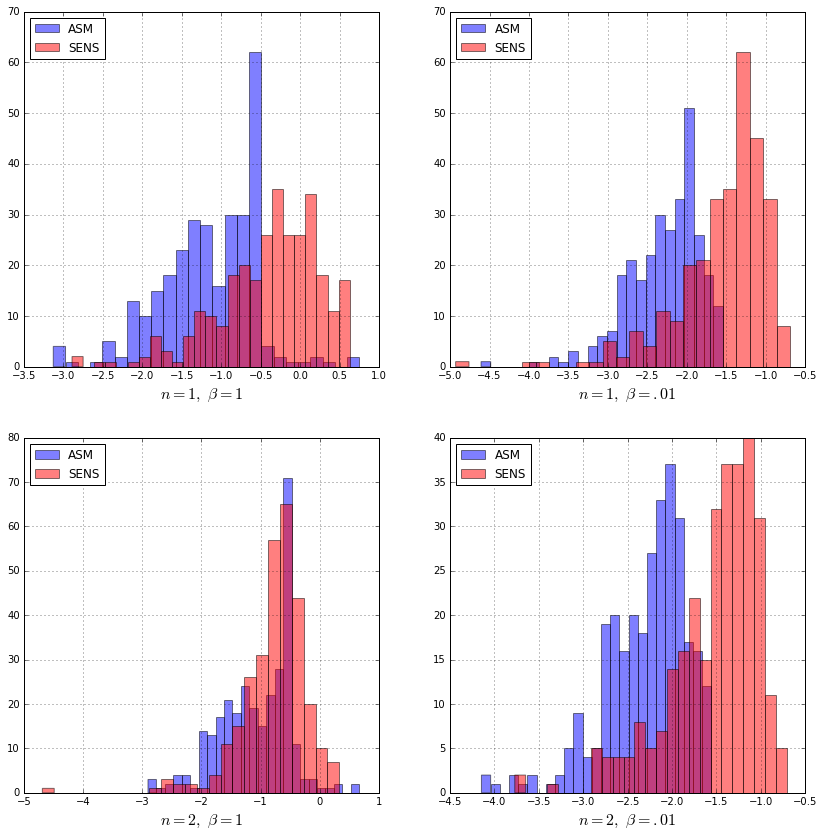

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14)); axes = axes.reshape(4)

ss_short.partition(1); ss_long.partition(1)

axes[0].hist(np.log10(np.abs(y_long-RS_long_AS.predict(x.dot(ss_long.W1))[0])/np.abs(
    y_long)), bins=25, alpha=.5, label='ASM')
axes[0].hist(np.log10(np.abs(y_long-RS_long_SENS.predict
    (x[:,SENS_long_v1][:,None])[0])/np.abs(y_long)),
    bins=25, color='r', alpha=.5, label='SENS')
axes[0].grid(True)
axes[0].legend(loc=2)
axes[0].set_xlabel(r'$n=1,\ \beta=1$', fontsize=16)

axes[1].hist(np.log10(np.abs(y_short-RS_short_AS.predict(x.dot(ss_short.W1))[0])/np.abs(
    y_short)),bins=25, alpha=.5, label='ASM')
axes[1].hist(np.log10(np.abs(y_short-RS_short_SENS.predict
    (x[:,SENS_short_v1][:,None])[0])/np.abs(y_short)),
    bins=25, color='r', alpha=.5, label='SENS')
axes[1].grid(True)
axes[1].legend(loc=2)
axes[1].set_xlabel(r'$n=1,\ \beta=.01$', fontsize=16)

ss_short.partition(2); ss_long.partition(2)

axes[2].hist(np.log10(np.abs(y_long-RS_long_AS2.predict(x.dot(ss_long.W1))[0])/np.abs(
    y_long)), bins=25, alpha=.5, label='ASM')
axes[2].hist(np.log10(np.abs(y_long-RS_long_SENS2.predict
    (x[:,[SENS_long_v1,SENS_long_v2]])[0])/np.abs(y_long)),
    bins=25, color='r', alpha=.5, label='SENS')
axes[2].grid(True)
axes[2].legend(loc=2)
axes[2].set_xlabel(r'$n=2,\ \beta=1$', fontsize=16)

axes[3].hist(np.log10(np.abs(y_short-RS_short_AS2.predict(x.dot(ss_short.W1))[0])/np.abs(
    y_short)),bins=25, alpha=.5, label='ASM')
axes[3].hist(np.log10(np.abs(y_short-RS_short_SENS2.predict
    (x[:,[SENS_short_v1,SENS_short_v2]])[0])/np.abs(y_short)),
    bins=25, color='r', alpha=.5, label='SENS')
axes[3].grid(True)
axes[3].legend(loc=2)
axes[3].set_xlabel(r'$n=2,\ \beta=.01$', fontsize=16)

In each case, we see the active subspace histogram (ASM) is significantly left-shifted compared to the locally constructed subspace (SENS), meaning the active subspace tends to result in less error than the local method.

Lastly, we compare the active subspace kriging approximation with a kriging surface trained on the full input space, $\mathcal R^{100}$. We construct kriging surfaces with a linear mean term and 1000 training points in the full input space.

In [9]:
#Kriging surfaces in the full space with linear mean terms
RS_long_Full = ac.utils.response_surfaces.RadialBasisApproximation(1)
RS_short_Full = ac.utils.response_surfaces.RadialBasisApproximation(1)

#Training inputs
x_full = np.random.multivariate_normal(np.zeros(100), np.eye(100), 1000)

#Training output values
y_long_full = ac.utils.simrunners.SimulationRunner(solver_long.qoi).run(x_full)
y_short_full = ac.utils.simrunners.SimulationRunner(solver_short.qoi).run(x_full)

#Train the full response surfaces
RS_long_Full.train(x_full, y_long_full)
RS_short_Full.train(x_full, y_short_full)

To compare these approximations, we draw 500 random points and compute true outputs at these values and then plot histograms of log relative errors, as above, using these testing points with the 1- and 2-dimensional subspaces and the full response surfaces.

In [10]:
#Testing points
x_test = np.random.multivariate_normal(np.zeros(100), np.eye(100), 500)

#True outputs at testing points
f_long_true = ac.utils.simrunners.SimulationRunner(solver_long.qoi).run(x_test)
f_short_true = ac.utils.simrunners.SimulationRunner(solver_short.qoi).run(x_test)

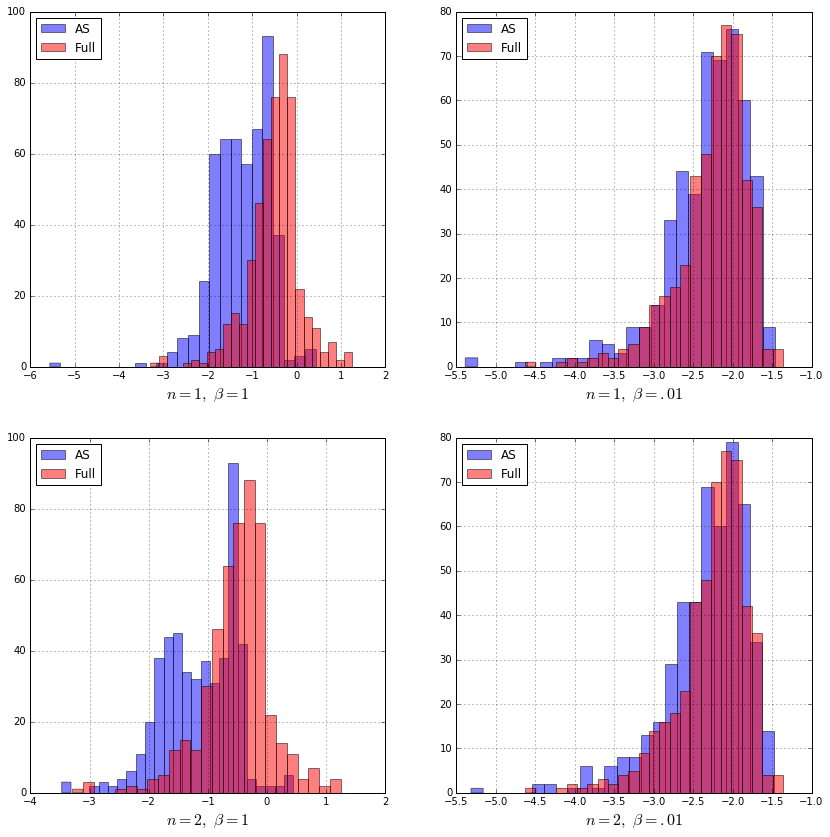

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14)); axes = axes.reshape(4)

ss_short.partition(1); ss_long.partition(1)

axes[0].hist(np.log10(np.abs(f_long_true-RS_long_AS.predict(x_test.dot(ss_long.W1))[0])\
    /np.abs(f_long_true)), bins=25, alpha=.5, label='AS')
axes[0].hist(np.log10(np.abs(f_long_true-RS_long_Full.predict
    (x_test)[0])/np.abs(f_long_true)),
    bins=25, color='r', alpha=.5, label='Full')
axes[0].grid(True)
axes[0].legend(loc=2)
axes[0].set_xlabel(r'$n=1,\ \beta=1$', fontsize=16)

axes[1].hist(np.log10(np.abs(f_short_true-RS_short_AS.predict(x_test.dot(ss_short.W1))[0])\
    /np.abs(f_short_true)), bins=25, alpha=.5, label='AS')
axes[1].hist(np.log10(np.abs(f_short_true-RS_short_Full.predict
    (x_test)[0])/np.abs(f_short_true)),
    bins=25, color='r', alpha=.5, label='Full')
axes[1].grid(True)
axes[1].legend(loc=2)
axes[1].set_xlabel(r'$n=1,\ \beta=.01$', fontsize=16)

ss_short.partition(2); ss_long.partition(2)

axes[2].hist(np.log10(np.abs(f_long_true-RS_long_AS2.predict(x_test.dot(ss_long.W1))[0])\
    /np.abs(f_long_true)), bins=25, alpha=.5, label='AS')
axes[2].hist(np.log10(np.abs(f_long_true-RS_long_Full.predict
    (x_test)[0])/np.abs(f_long_true)),
    bins=25, color='r', alpha=.5, label='Full')
axes[2].grid(True)
axes[2].legend(loc=2)
axes[2].set_xlabel(r'$n=2,\ \beta=1$', fontsize=16)

axes[3].hist(np.log10(np.abs(f_short_true-RS_short_AS2.predict(x_test.dot(ss_short.W1))[0])\
    /np.abs(f_short_true)), bins=25, alpha=.5, label='AS')
axes[3].hist(np.log10(np.abs(f_short_true-RS_short_Full.predict
    (x_test)[0])/np.abs(f_short_true)),
    bins=25, color='r', alpha=.5, label='Full')
axes[3].grid(True)
axes[3].legend(loc=2)
axes[3].set_xlabel(r'$n=2,\ \beta=.01$', fontsize=16)

We see significant improvement in error with the long correlation by using the active subspace rather than the full response surface. In the short correlation case, there is little difference in the histograms; this is because, in the paper, the kriging code used was unable to recognize the linear nature of the quantity of interest, and so obtained a poor approximation compared to the kriging code we use here, which does detect the linearity in the short correlation case.

Overall, our explorations here demonstrate that using active subspaces can lead to significantly better approximations of complex functions than methods of dimension reduction based on local sensitivity or approximations based on the full input space (which may be infeasible to construct because of simulation expense). The only case in which we see little to no improvement by using active subspaces over the full input space is with the short correlation length, in which the function of interest is roughly linear, making approximation relatively trivial.